In [7]:
from utils import *
from tqdm import tqdm
from joblib import Parallel, delayed

### Percolation probability

When infection which started at the bottom of the system reaches on the top of it, we regard this trial as
percolated, and define the percolation probability as the ratio of percolated trials to total trials.

Show the dependence of the percolation probability (p) on the density p * pi * r0^2 for several values of lambda

In [17]:
N_pop = 200  # Fixed population size for these plots
r0_normal_val = 1.0 # Unit length for infection range

# Common simulation parameters from paper
w0_base_val = 1.0
alpha_normal_val = 2.0
gamma_recovery_prob_val = 1.0 # y=1

num_mc_runs_per_point = 100 # Reduced for faster execution, paper uses 1000

density_param_values = np.linspace(0.1, 25, 26) # ρπr₀² values for x-axis (0 to 25 with 26 points)
lambda_ss_values = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0] # Fractions of superspreaders

superspreader_models_to_run = {
    "Strong Infectiousness": "strong", # Fig 3
    "Hub Model": "hub"                 # Fig 4
}

In [15]:
def run_single_simulation_percolatation(L_system, lambda_val, model_type_key):
    S_h, I_h, R_h, t_h, individuals = run_sir_simulation(
                    N=N_pop, L=L_system, r0_normal=r0_normal_val,
                    w0_base=w0_base_val, alpha_normal=alpha_normal_val, 
                    gamma_recovery_prob=gamma_recovery_prob_val,
                    lambda_ss_fraction=lambda_val, 
                    superspreader_model_type=model_type_key,
                    initial_infected_count=1,
                    max_time_steps=1000,
                    verbose=False
                )
    return 1 if min(S_h) == 0 and max(I_h) > 0 else 0



--- Running for: Strong Infectiousness ---
  λ = 0.0


λ=0.0: 100%|██████████| 26/26 [00:28<00:00,  1.08s/it]


  λ = 0.2


λ=0.2: 100%|██████████| 26/26 [00:42<00:00,  1.64s/it]


  λ = 0.4


λ=0.4: 100%|██████████| 26/26 [00:56<00:00,  2.19s/it]


  λ = 0.6


λ=0.6: 100%|██████████| 26/26 [01:03<00:00,  2.43s/it]


  λ = 0.8


λ=0.8: 100%|██████████| 26/26 [01:06<00:00,  2.58s/it]


  λ = 1.0


λ=1.0: 100%|██████████| 26/26 [01:10<00:00,  2.69s/it]



--- Running for: Hub Model ---
  λ = 0.0


λ=0.0: 100%|██████████| 26/26 [00:41<00:00,  1.59s/it]


  λ = 0.2


λ=0.2: 100%|██████████| 26/26 [00:51<00:00,  1.99s/it]


  λ = 0.4


λ=0.4: 100%|██████████| 26/26 [00:55<00:00,  2.13s/it]


  λ = 0.6


λ=0.6: 100%|██████████| 26/26 [00:58<00:00,  2.23s/it]


  λ = 0.8


λ=0.8: 100%|██████████| 26/26 [01:03<00:00,  2.45s/it]


  λ = 1.0


λ=1.0: 100%|██████████| 26/26 [01:03<00:00,  2.43s/it]


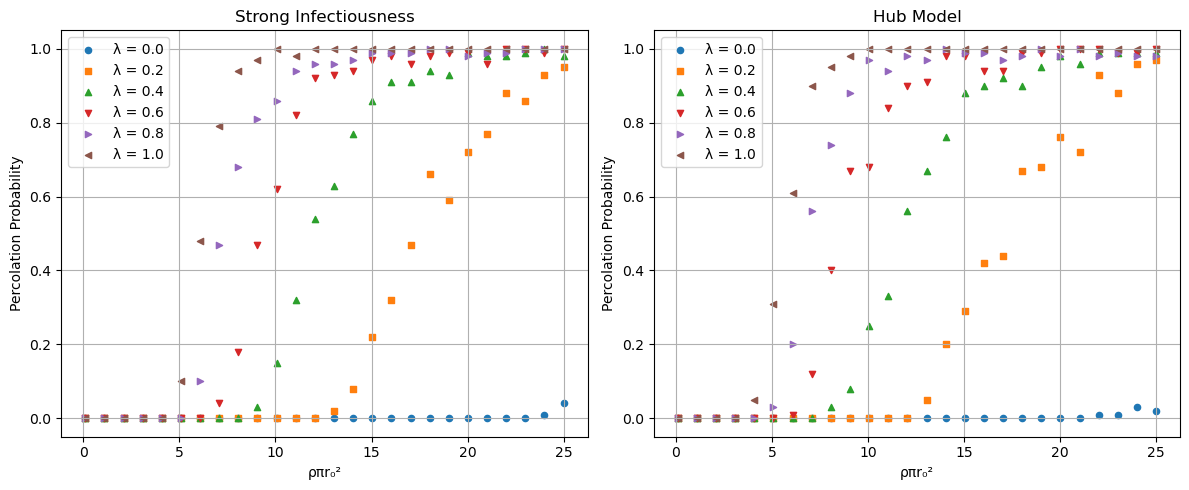

In [18]:
plt.figure(figsize=(12, 5))
plot_idx = 1

# Create a list of markers with at least as many entries as lambda_ss_values.
marker_list = ['o', 's', '^', 'v', '>', '<', 'd', 'p', '*', 'h', 'H', 'D', '+', 'x', '|', '_', '1', '2', '3', '4', '8']

for fig_title, model_type_key in superspreader_models_to_run.items():
    plt.subplot(1, 2, plot_idx)
    print(f"\n--- Running for: {fig_title} ---")
    
    for i, lambda_val in enumerate(lambda_ss_values):
        marker = marker_list[i % len(marker_list)]
        print(f"  λ = {lambda_val:.1f}")
        percolation_probabilities = []
        for density_param in tqdm(density_param_values, desc=f"λ={lambda_val:.1f}", disable=False):
            if density_param == 0:
                percolation_probabilities.append(0.0)
                continue

            L_system = np.sqrt((N_pop * np.pi * r0_normal_val**2) / density_param)
            
            # Run simulations in parallel (using 8 workers)
            results = Parallel(n_jobs=8)(
                delayed(run_single_simulation_percolatation)(L_system, lambda_val, model_type_key)
                for _ in range(num_mc_runs_per_point)
            )
            prob = sum(results) / num_mc_runs_per_point
            percolation_probabilities.append(prob)
        
        plt.scatter(density_param_values, percolation_probabilities, marker=marker, s=20, label=f"λ = {lambda_val:.1f}")
    
    plt.xlabel("ρπr₀²")
    plt.ylabel("Percolation Probability")
    plt.title(f"{fig_title}")
    plt.ylim(-0.05, 1.05)
    plt.grid(True)
    plt.legend()
    plot_idx += 1

plt.tight_layout()
plt.show()

### Propagation Speed
We define the velocity of propagation as the velocity of front line. Let rf be the distance between the initial
infected individual and the furthest infected individual from it.

In [11]:
def run_single_simulation_velocity(L_system, lambda_val, model_type_key):
    S_h, I_h, R_h, t_h, history_hub = run_sir_simulation_with_history(
        N=N_pop, L=L_system, r0_normal=r0_normal_val,
        w0_base=w0_base_val, alpha_normal=alpha_normal_val, 
        gamma_recovery_prob=gamma_recovery_prob_val,
        lambda_ss_fraction=lambda_val, 
        superspreader_model_type=model_type_key,
        initial_infected_count=1,
        max_time_steps=1000,
        verbose=False
    )

    # Find the initial infected individual's position (at t=0)
    initial_infected_idx = None
    for idx, ind in enumerate(history_hub[0]):
        if ind['state'] == INFECTED:
            initial_infected_idx = idx
            break

    if initial_infected_idx is None:
        raise ValueError("No initially infected individual found in history_hub[0]")

    initial_pos = history_hub[0][initial_infected_idx]['pos']

    # For each time step, find the furthest infected individual's distance from the initial infected
    avg_velocity = 0
    for timesteps, individuals in enumerate(history_hub):
        infected_positions = [ind['pos'] for ind in individuals if ind['state'] == INFECTED]
        if infected_positions:
            distances = [distance_periodic(infected_pos, initial_pos, L_system) for infected_pos in infected_positions]
            rf = max(distances)
        else:
            rf = 0.0
        current_velocity = rf / (r0_normal_val * (timesteps + 1))
        avg_velocity += current_velocity
    avg_velocity /= len(history_hub)  # Average over all time steps
    return avg_velocity


--- Running for: Strong Infectiousness ---
  λ = 0.000
  λ = 0.050
  λ = 0.100
  λ = 0.150
  λ = 0.200
  λ = 0.250
  λ = 0.300
  λ = 0.350
  λ = 0.400
  λ = 0.450
  λ = 0.500
  λ = 0.550
  λ = 0.600
  λ = 0.650
  λ = 0.700
  λ = 0.750
  λ = 0.800
  λ = 0.850
  λ = 0.900
  λ = 0.950
  λ = 1.000

--- Running for: Hub Model ---
  λ = 0.000
  λ = 0.050
  λ = 0.100
  λ = 0.150
  λ = 0.200
  λ = 0.250
  λ = 0.300
  λ = 0.350
  λ = 0.400
  λ = 0.450
  λ = 0.500
  λ = 0.550
  λ = 0.600
  λ = 0.650
  λ = 0.700
  λ = 0.750
  λ = 0.800
  λ = 0.850
  λ = 0.900
  λ = 0.950
  λ = 1.000


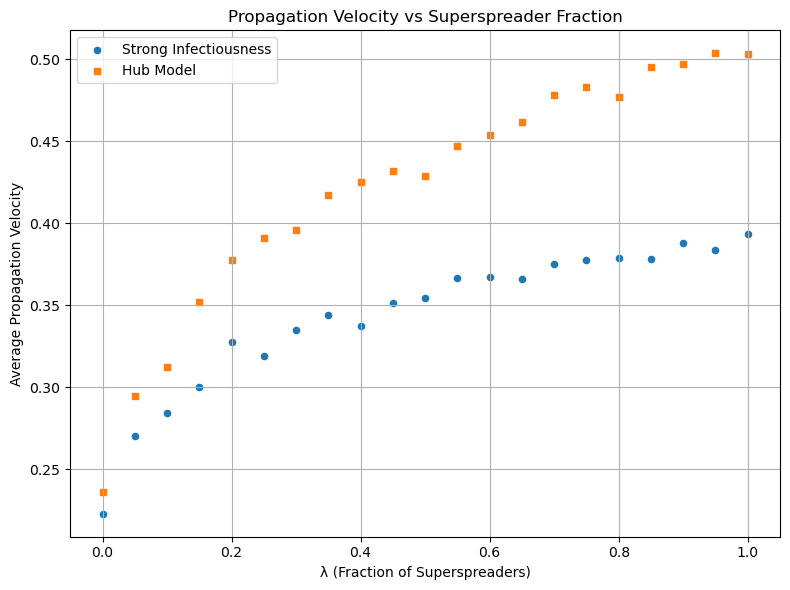

In [13]:
markers = ['o', 's']  # Different markers for each model
plt.figure(figsize=(8, 6))

density_param = 20
lambda_ss_values = np.linspace(0.0, 1.0, 21)  # Fractions of superspreaders from 0 to 1
for marker, (fig_title, model_type_key) in zip(markers, superspreader_models_to_run.items()):
    print(f"\n--- Running for: {fig_title} ---")
    results = []
    for lambda_val in lambda_ss_values:
        print(f"  λ = {lambda_val:.3f}")
        L_system = np.sqrt((N_pop * np.pi * r0_normal_val**2) / density_param)
        
        avg_velocities = Parallel(n_jobs=8)(
            delayed(run_single_simulation_velocity)(L_system, lambda_val, model_type_key)
            for _ in range(num_mc_runs_per_point)
        )
        avg_velocity = np.mean(avg_velocities)
        results.append(avg_velocity)
    
    plt.scatter(lambda_ss_values, results, marker=marker, s=20, label=fig_title)

plt.xlabel("λ (Fraction of Superspreaders)")
plt.ylabel("Average Propagation Velocity")
plt.title("Propagation Velocity vs Superspreader Fraction")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig("propagation_velocity_vs_superspreader_fraction.png", dpi=300, bbox_inches='tight')
plt.show()
